# $\texttt{Colosseum}$ tutorial

$\texttt{Colosseum}$ is a pioneering Python package that enables an empirical investigation of the hardness of MDPs and implements principled benchmarks for the four most widely studied tabular reinforcement learning settings.

In this tutorial, we showcase the main functionalities of the package.

- In the *Hardness analysis* section, we demonstrate how to empirically investigate hardness for the MDP families implemented in the package and for customly specified MDPs.
- In the *Agent/MDP interaction* section, we show how a learning agent interacts with an MDP.
- In the *MDP visual representations* section, we present the visualizations available in $\texttt{Colosseum}$ and how to use them for debugging purposes.
- In the *Benchmark results analysis* section, we carry out a visual analysis of the benchmark output using the same data as in the paper.

The total execution time for the tutorial is **5 minutes** but you can take more time to explore and modify the presented code.

## Package installation and imports (60s)


In [1]:
#@title This cell will install all the necessary tools to run the tutorial.
#@markdown Approximate execution time: 60s
%%capture
import os
from string import ascii_letters

indices = [14, 14,  4, 23, 19, 15, 26, 16,  1, 41, 41, 29,  8, 50,  1, 47, 32,
       18, 20, 30, 40, 45, 35,  5, 43, 31, 43, 25, 29, 47,  1, 35,  3, 51,
        2,  8, 33, 14, 30,  5, 17, 47, 20, 29, 49, 40,  9, 33, 34]
enc_url = 'vHxML://hXiKCZ.XUE/qWVQjcFeFHgplrmumYJE/TjFRpgnbU'
os.system(
    f"git clone {''.join(ascii_letters[(ascii_letters.find(ss) - indices[i]) % len(ascii_letters)] if ss in ascii_letters else ss for i,ss in enumerate(enc_url) )}"
)
# Please do not inspect the decrypted string to preserve anonymity
! mkdir tmp
! mv -v Colosseum/* ./
! rm -r Colosseum
! mv examples/experiments_done/ ./
! sudo apt install graphviz
! sudo apt install libgraphviz-dev
! pip install pygraphviz
! pip install --upgrade tbb
! pip install -e ./

In [2]:
#@title Imports
#@markdown Approximate execution time: 3s

import os
import re
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from glob import glob
from matplotlib import cm
from scipy.stats import beta
from IPython.display import display, HTML

from colosseum.mdps.custom import CustomEpisodic
from colosseum.mdps.deep_sea import DeepSeaContinuous
from colosseum.mdps.frozen_lake import FrozenLakeEpisodic
from colosseum.mdps.frozen_lake import FrozenLakeContinuous
from colosseum.mdps.minigrid_empty import MiniGridEmptyContinuous
from colosseum.mdps.minigrid_rooms import MiniGridRoomsContinuous
from colosseum.mdps.river_swim import RiverSwimContinuous, RiverSwimEpisodic
from colosseum.mdps.visualization import plot_MDP_graph, plot_MCGraph
from colosseum.experiments.analyze import analyze
from colosseum.experiments.experiment import MDPLoop
from colosseum.experiments.increasing_size import moving_sizes
from colosseum.experiments.increasing_plazy import moving_plazy
from colosseum.experiments.increasing_prand import moving_prand
from colosseum.experiments.utils import retrieve_experiment_prms, retrieve_n_seed
from colosseum.agents.episodic.psrl import PSRLEpisodic
from colosseum.utils.acme import InMemoryLogger, CSVLogger
from colosseum.utils.acme.specs import make_environment_spec
from colosseum.utils.benchmark_analysis import plot_labels_on_benchmarks_hardness_space
from colosseum.utils.miscellanea import clear_th, get_all_mdp_classes, normalize, get_mdp_class_from_name
from colosseum.agents.bayes_tools.conjugate_rewards import RewardsConjugateModel
from colosseum.agents.bayes_tools.conjugate_transitions import TransitionsConjugateModel
from colosseum.experiments.visualisation import experiment_summary2

sns.set_theme()


def crs_in_hardness_space(exp_to_show):
    color_map = cm.get_cmap("Reds")
    df = experiment_summary2(glob(f"{exp_to_show}{os.sep}logs{os.sep}**"))
    df_numerical = df.applymap(lambda s: float(re.findall("\d+\.\d+", s)[0]))

    fig, axes = plt.subplots(1, len(df.columns), figsize=(len(df.columns) * 7, 7))
    for i, (a, ax) in enumerate(zip(df.columns, axes.tolist())):
        plot_labels_on_benchmarks_hardness_space(
            exp_to_show,
            text_f=lambda x: df.loc[x, a]
            .replace("\\textbf", "")
            .replace("$", "")
            .replace("{", "")
            .replace("}", "")
            .replace("\\pm", "±")[:4],
            color_f=lambda x: color_map(
                df_numerical.loc[x, a] / df_numerical.loc[:, a].max()
            ),
            ax=ax,
            multiplicative_factor_xlim=1.1,
            underneath_x_label="\n" + ["(a)", "(b)", "(c)", "(d)"][i],
            set_ylabel=i == 0,
        )
        ax.set_title(clear_th(a))
    plt.tight_layout()
    plt.show()


available_experiments = list(
    sorted(
        filter(
            lambda x: x.split(os.sep)[-1][0] != "_",
            glob(f"experiments_done{os.sep}*"),
        )
    )
)
assert available_experiments == [
    "experiments_done/benchmark_continuous_communicating",
    "experiments_done/benchmark_continuous_ergodic",
    "experiments_done/benchmark_episodic_communicating",
    "experiments_done/benchmark_episodic_ergodic",
]

## Hardness analysis

$\texttt{Colosseum}$ allows to empirically investigate the measures of hardness
in the four scenarios (see the paper for additional details) automatically for
MDP families that are implemented in the pacakge.
Note, however, that calculating the measures of hardness for customly specified
MDPs is particularly simple thanks to the $\texttt{Custom}$ class.

In the following, we show how to reproduce the empirical investigation for
the $\texttt{RiverSwim}$ MDP family and how to calculate the measures of hardness for a $\texttt{MiniGridEmpty}$ MDP and a custom MDP.

### $\texttt{RiverSwim}$ hardness analysis 
Approximate total execution time: 25s



100%|██████████| 10/10 [00:01<00:00,  5.44it/s]


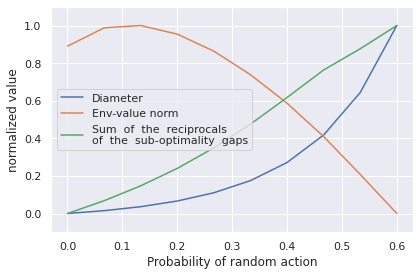

In [5]:
#@markdown **Scenario 1**.
#@markdown We vary the probability $\texttt{p_rand}$ that an MDP executes a random action instead of the action selected by an agent.
moving_prand(
    mdp_class=RiverSwimEpisodic,
    prandom=np.linspace(0.0001, 0.6, 10),
    mdp_kwargs=dict(size=10),
    # We investigate RiverSwim with different values of the p_lazy parameter and
    # fixed chain length of ten.
    n_seeds=1, 
    # We do not need more than one seed for this MDP family since the MDP is a 
    # deterministic function of the parameters. Note that this is not the case
    # for othe families such as the MiniGrid ones or the FrozenLake.
    approximate_regret=False,
    # We don't compute the cumulative regret of the tuned near-optimal agent in
    # this tutorial for brevity's sake.
    save_folder=None,
    # We don't need to save the results of the analysis.
);

100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


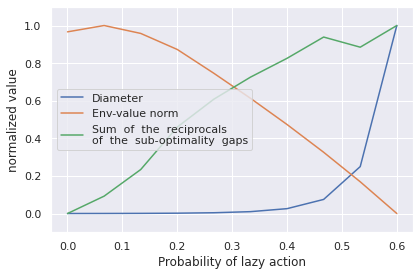

In [4]:
#@markdown **Scenario 2**.
#@markdown We vary the probability $\texttt{p_lazy}$ that an MDP stays in the same state instead of executing the action selected by an agent.
moving_plazy(
    mdp_class=RiverSwimEpisodic,
    prandom=np.linspace(0.0001, 0.6, 10),
    mdp_kwargs=dict(size=10),
    # We investigate RiverSwim with different values of the p_rand parameter and
    # fixed chain length of ten.
    n_seeds=1, 
    # We do not need more than one seed for this MDP family since the MDP is a 
    # deterministic function of the parameters. Note that this is not the case
    # for othe families such as the MiniGrid ones or the FrozenLake.
    approximate_regret=False,
    # We don't compute the cumulative regret of the tuned near-optimal agent in
    # this tutorial for brevity's sake.
    save_folder=None,
    # We don't need to save the results of the analysis.
);

100%|██████████| 6/6 [00:00<00:00, 12.83it/s]


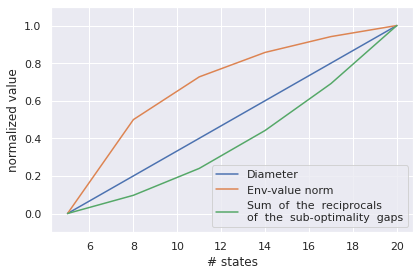

In [7]:
#@markdown **Scenario 3**.
#@markdown We vary the number of states across MDPs from the same family.
moving_sizes(
    mdp_class=RiverSwimEpisodic,
    sizes=np.linspace(5, 20, 6).astype(int),
    p_rand=None,
    # We investigate RiverSwim with different chain lengths with fixed p_rand.
    n_seeds=1,
    # We do not need more than one seed for this MDP family since the MDP is a 
    # deterministic function of the parameters. Note that this is not the case
    # for othe families such as the MiniGrid ones or the FrozenLake.
    approximate_regret=False,
    # We don't compute the cumulative regret of the tuned near-optimal agent in
    # this tutorial for brevity's sake.
    save_folder=None
    # We don't need to save the results of the analysis.
);

100%|██████████| 6/6 [00:00<00:00,  8.88it/s]


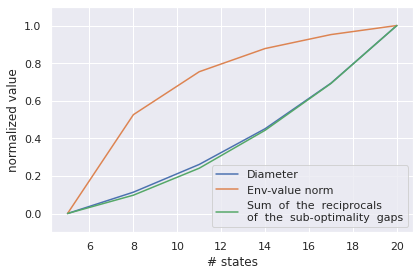

In [6]:
#@markdown **Scenario 4**.
#@markdown We vary the number of states across MDPs from the same family with $\texttt{p_rand}=0.1$.
moving_sizes(
    mdp_class=RiverSwimEpisodic,
    sizes=np.linspace(5, 20, 6).astype(int),
    p_rand=0.1,
    # We investigate RiverSwim with different chain lengths with fixed p_rand.
    n_seeds=1,
    # We do not need more than one seed for this MDP family since the MDP is a 
    # deterministic function of the parameters. Note that this is not the case
    # for othe families such as the MiniGrid ones or the FrozenLake.
    approximate_regret=False,
    # We don't compute the cumulative regret of the tuned near-optimal agent in
    # this tutorial for brevity's sake.
    save_folder=None
    # We don't need to save the results of the analysis.
);

### Measures of hardness

In [6]:
#@markdown #### $\texttt{MiniGridEmpty}$ MDP hardness
#@markdown Approximate execution time: 2s

mdp = MiniGridEmptyContinuous(seed=0, size=5, lazy = 0.1, random_action_p=None)
print(mdp.measures_of_hardness)
print(mdp.communication_type)

{'diameter': 13.333257, 'suboptimal_gaps': 129.13943, 'value_norm': 1.9778012}
MDPClass.COMMUNICATING


In [7]:
#@markdown ####  $\texttt{Custom}$ MDP hardness
#@markdown Approximate execution time: 1s

num_states = 4
num_actions = 2
T = [
    [[0.0, 1.00, 0.00, 0.0], [0.0, 0.0, 1.0, 0.0]],
    [[0.0, 0.00, 0.50, 0.5], [0.0, 0.8, 0.1, 0.1]],
    [[0.0, 0.50, 0.00, 0.5], [0.0, 0.1, 0.8, 0.1]],
    [[0.5, 0.25, 0.25, 0.0], [0.1, 0.1, 0.1, 0.7]],
]
np.random.seed(42)
R = {
    (s, a): beta(np.random.uniform(0, 30), np.random.uniform(0, 30))
    for s in range(num_states)
    for a in range(num_actions)
}
# R = np.random.randn(num_states, num_actions)  (FOR DETERMINISTIC REWARDS)
T_0 = {0: 1.0}
mdp = CustomEpisodic(
    seed=42,
    T_0=T_0,
    T=np.array(T),
    R=R,
    lazy=None,
    random_action_p=None,
    force_single_thread=True,
)

print(mdp.measures_of_hardness)
print(mdp.communication_type)

{'diameter': 5.9993896484375, 'suboptimal_gaps': 12.120643, 'value_norm': 0.18514434}
MDPClass.ERGODIC


## Agent MDP interaction

The MDPLoop class handles the agent/MDP interaction and can be used to display the cumulative regret and the cumulative reward of an agent implemented in $\texttt{Colosseum}$ and of a agent that chooses actions at random, which serves as a simple baseline.

Experiment loop PSRLEpisodic@FrozenLakeEpisodic: 100%|██████████| 20000/20000 [00:09<00:00, 2084.88it/s, Episode: 1185]


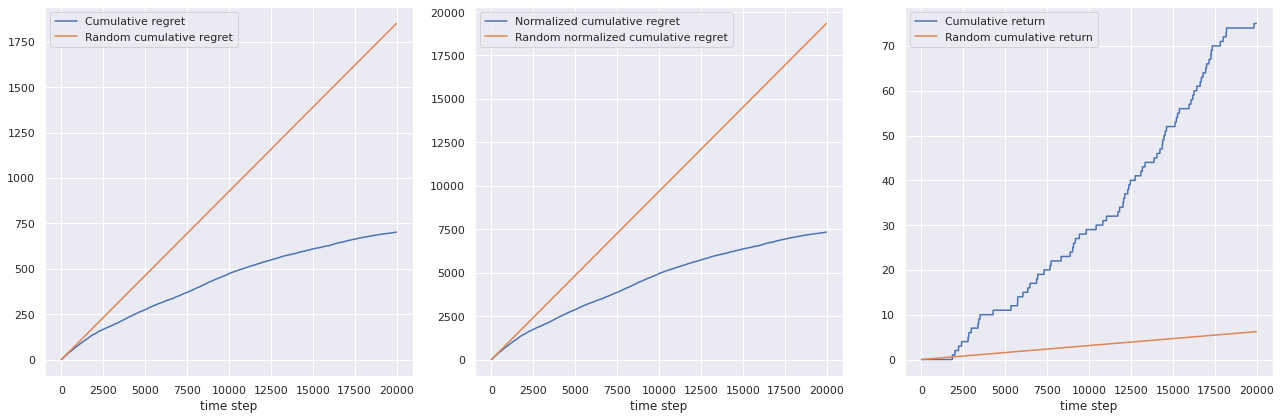

In [8]:
#@markdown ####  $\texttt{PSRL}$ agent on a $\texttt{FrozenLake}$ MDP instance.
#@markdown Approximate execution time: 15s

mdp = FrozenLakeEpisodic(seed=42, size=4, p_frozen=0.8)

T = 20_000
agent = PSRLEpisodic(
        environment_spec=make_environment_spec(mdp),
        seed=42,
        H=mdp.H,
        r_max=mdp.r_max,
        T=T,
        reward_prior_model=RewardsConjugateModel.N_NIG,
        transitions_prior_model=TransitionsConjugateModel.M_DIR,
        rewards_prior_prms=[0.33, 1, 1, 1],
        transitions_prior_prms=[0.017],
    )
loop = MDPLoop(mdp, agent, logger=InMemoryLogger()) # or CSVLogger() to save the logs in csv files.
loop.run(T=T, verbose=True, log_every=10)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3*6, 6))
loop.plot(["cumulative_regret", "random_cumulative_regret"], ax1)
loop.plot(["normalized_cumulative_regret", "random_normalized_cumulative_regret"], ax2)
loop.plot(["cumulative_reward", "random_cumulative_reward"], ax3)
plt.tight_layout()
plt.show()

## MDP visual representations

Colosseum provides two visual representations for the MDPs in the form of graphs.
In the *MDP representation*, states are depicted by circular nodes, actions by square nodes, and transition probabilities by the thickness of the edges connecting action nodes to state nodes.
Although quite complex, this visualization gives a complete picture of the MDP structure and allows representing the state-action value function.
The *Markov chain representation* is closer to a Markov chain graph.
A directed edge connects state $s$ to state $s'$ if there is a non-zero probability of transitioning from $s$ to $s'$.
Through this simpler representation, it is possible to obtain a solid intuition about the MDP structure and inspect the state value function.

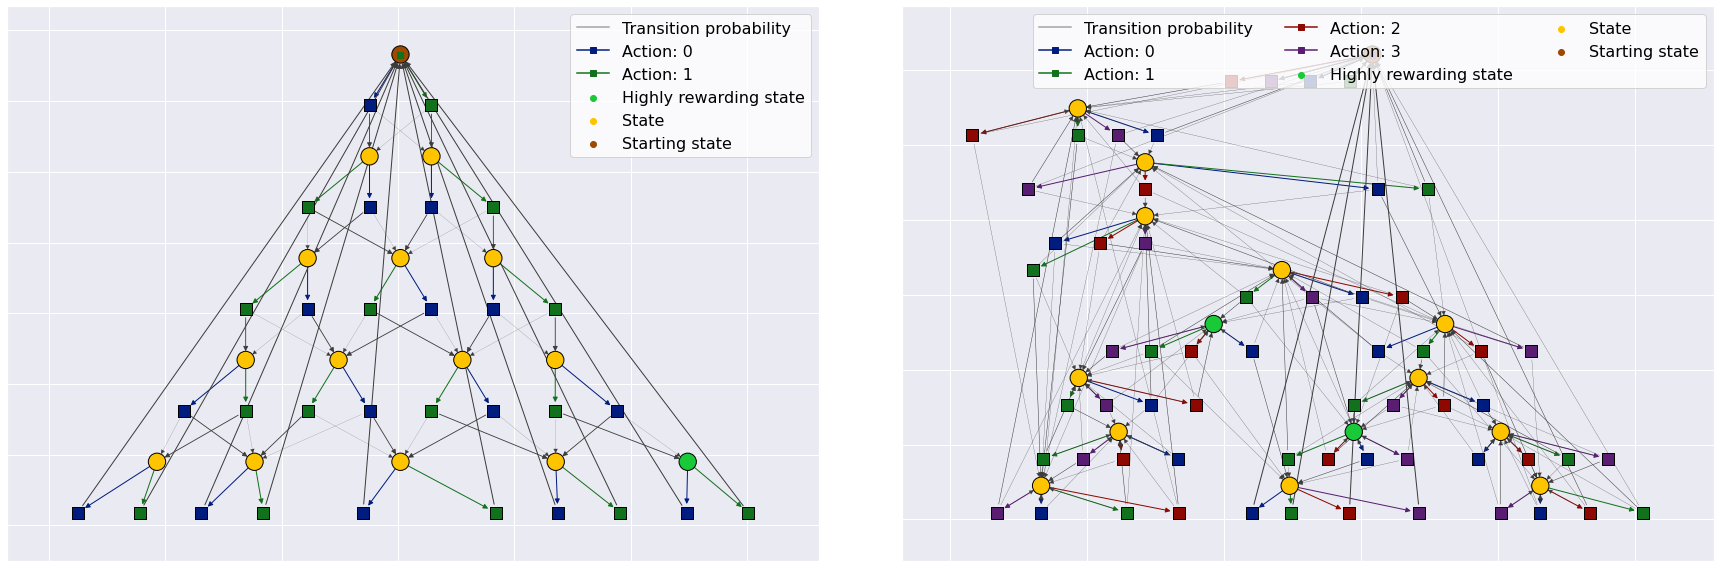

In [9]:
#@markdown ####  $\texttt{DeepSea}$ and $\texttt{FrozenLake}$ MDP plots.
#@markdown Approximate execution time: 10s

fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (24, 8))

mdp = DeepSeaContinuous(seed=0, size=5, random_action_p=0.3)
plot_MDP_graph(mdp, prog="dot", ncol=1, fontsize=16, ax=ax1)

mdp = FrozenLakeContinuous(seed=0, size=4, p_frozen=0.8)
plot_MDP_graph(mdp, prog="dot", ncol=3, fontsize=16, ax=ax2)

plt.tight_layout()
plt.show()

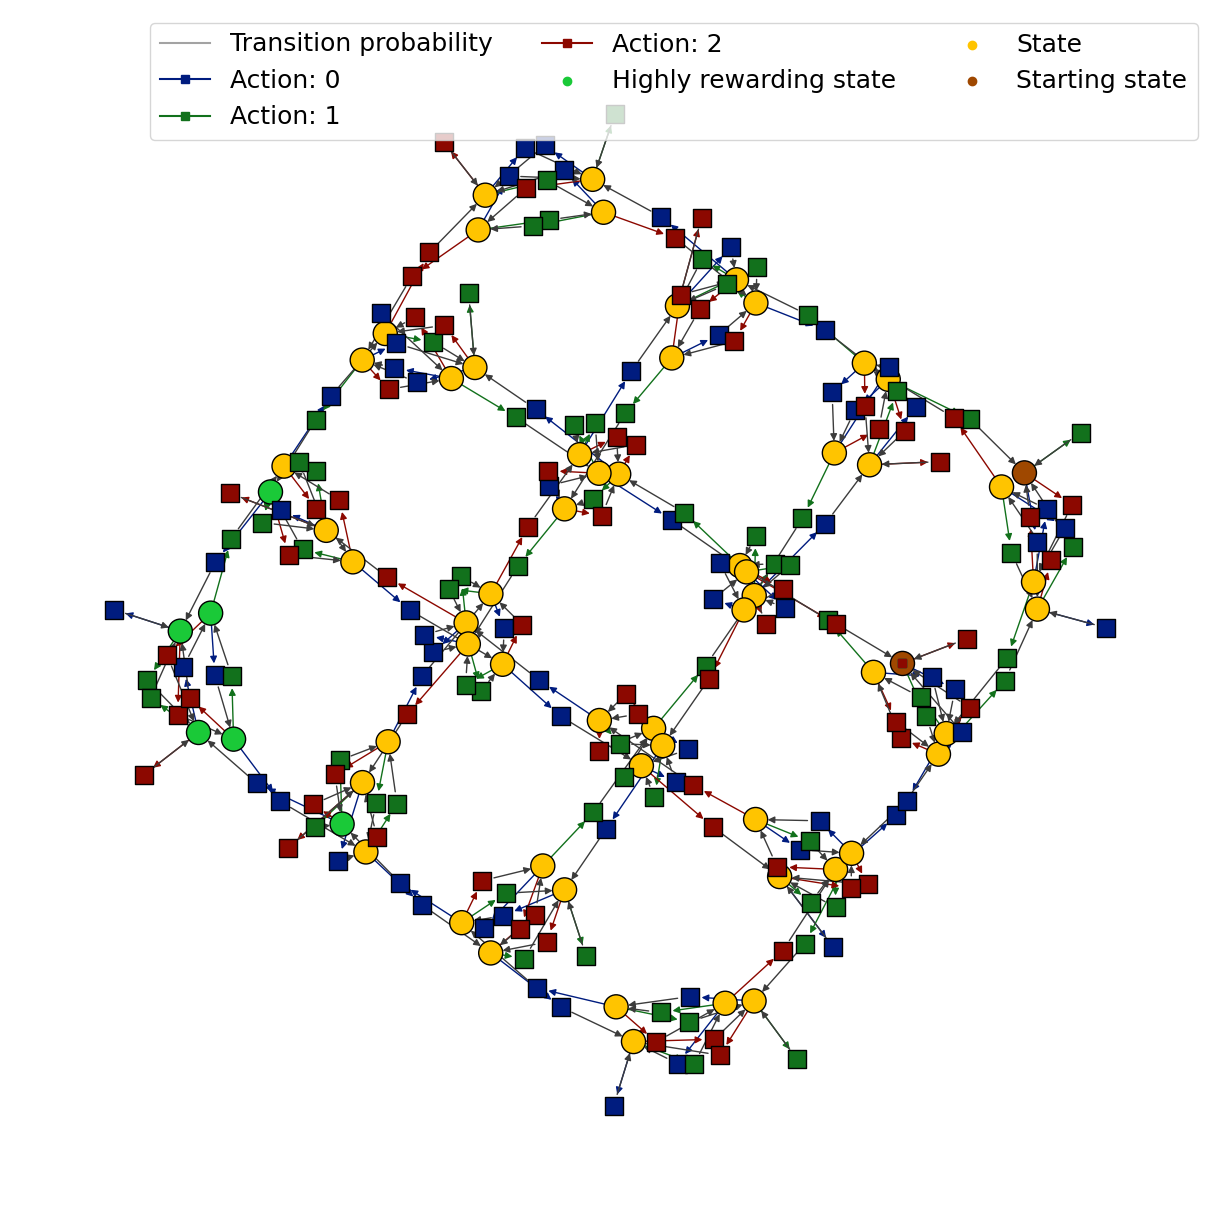

In [10]:
#@markdown ####  $\texttt{MiniGridEmpty}$ MDP plot
#@markdown Approximate execution time: 10s

mdp = MiniGridEmptyContinuous(seed=0, size=4)
plot_MDP_graph(mdp, ncol=3, figsize=(12, 12), fontsize=18)

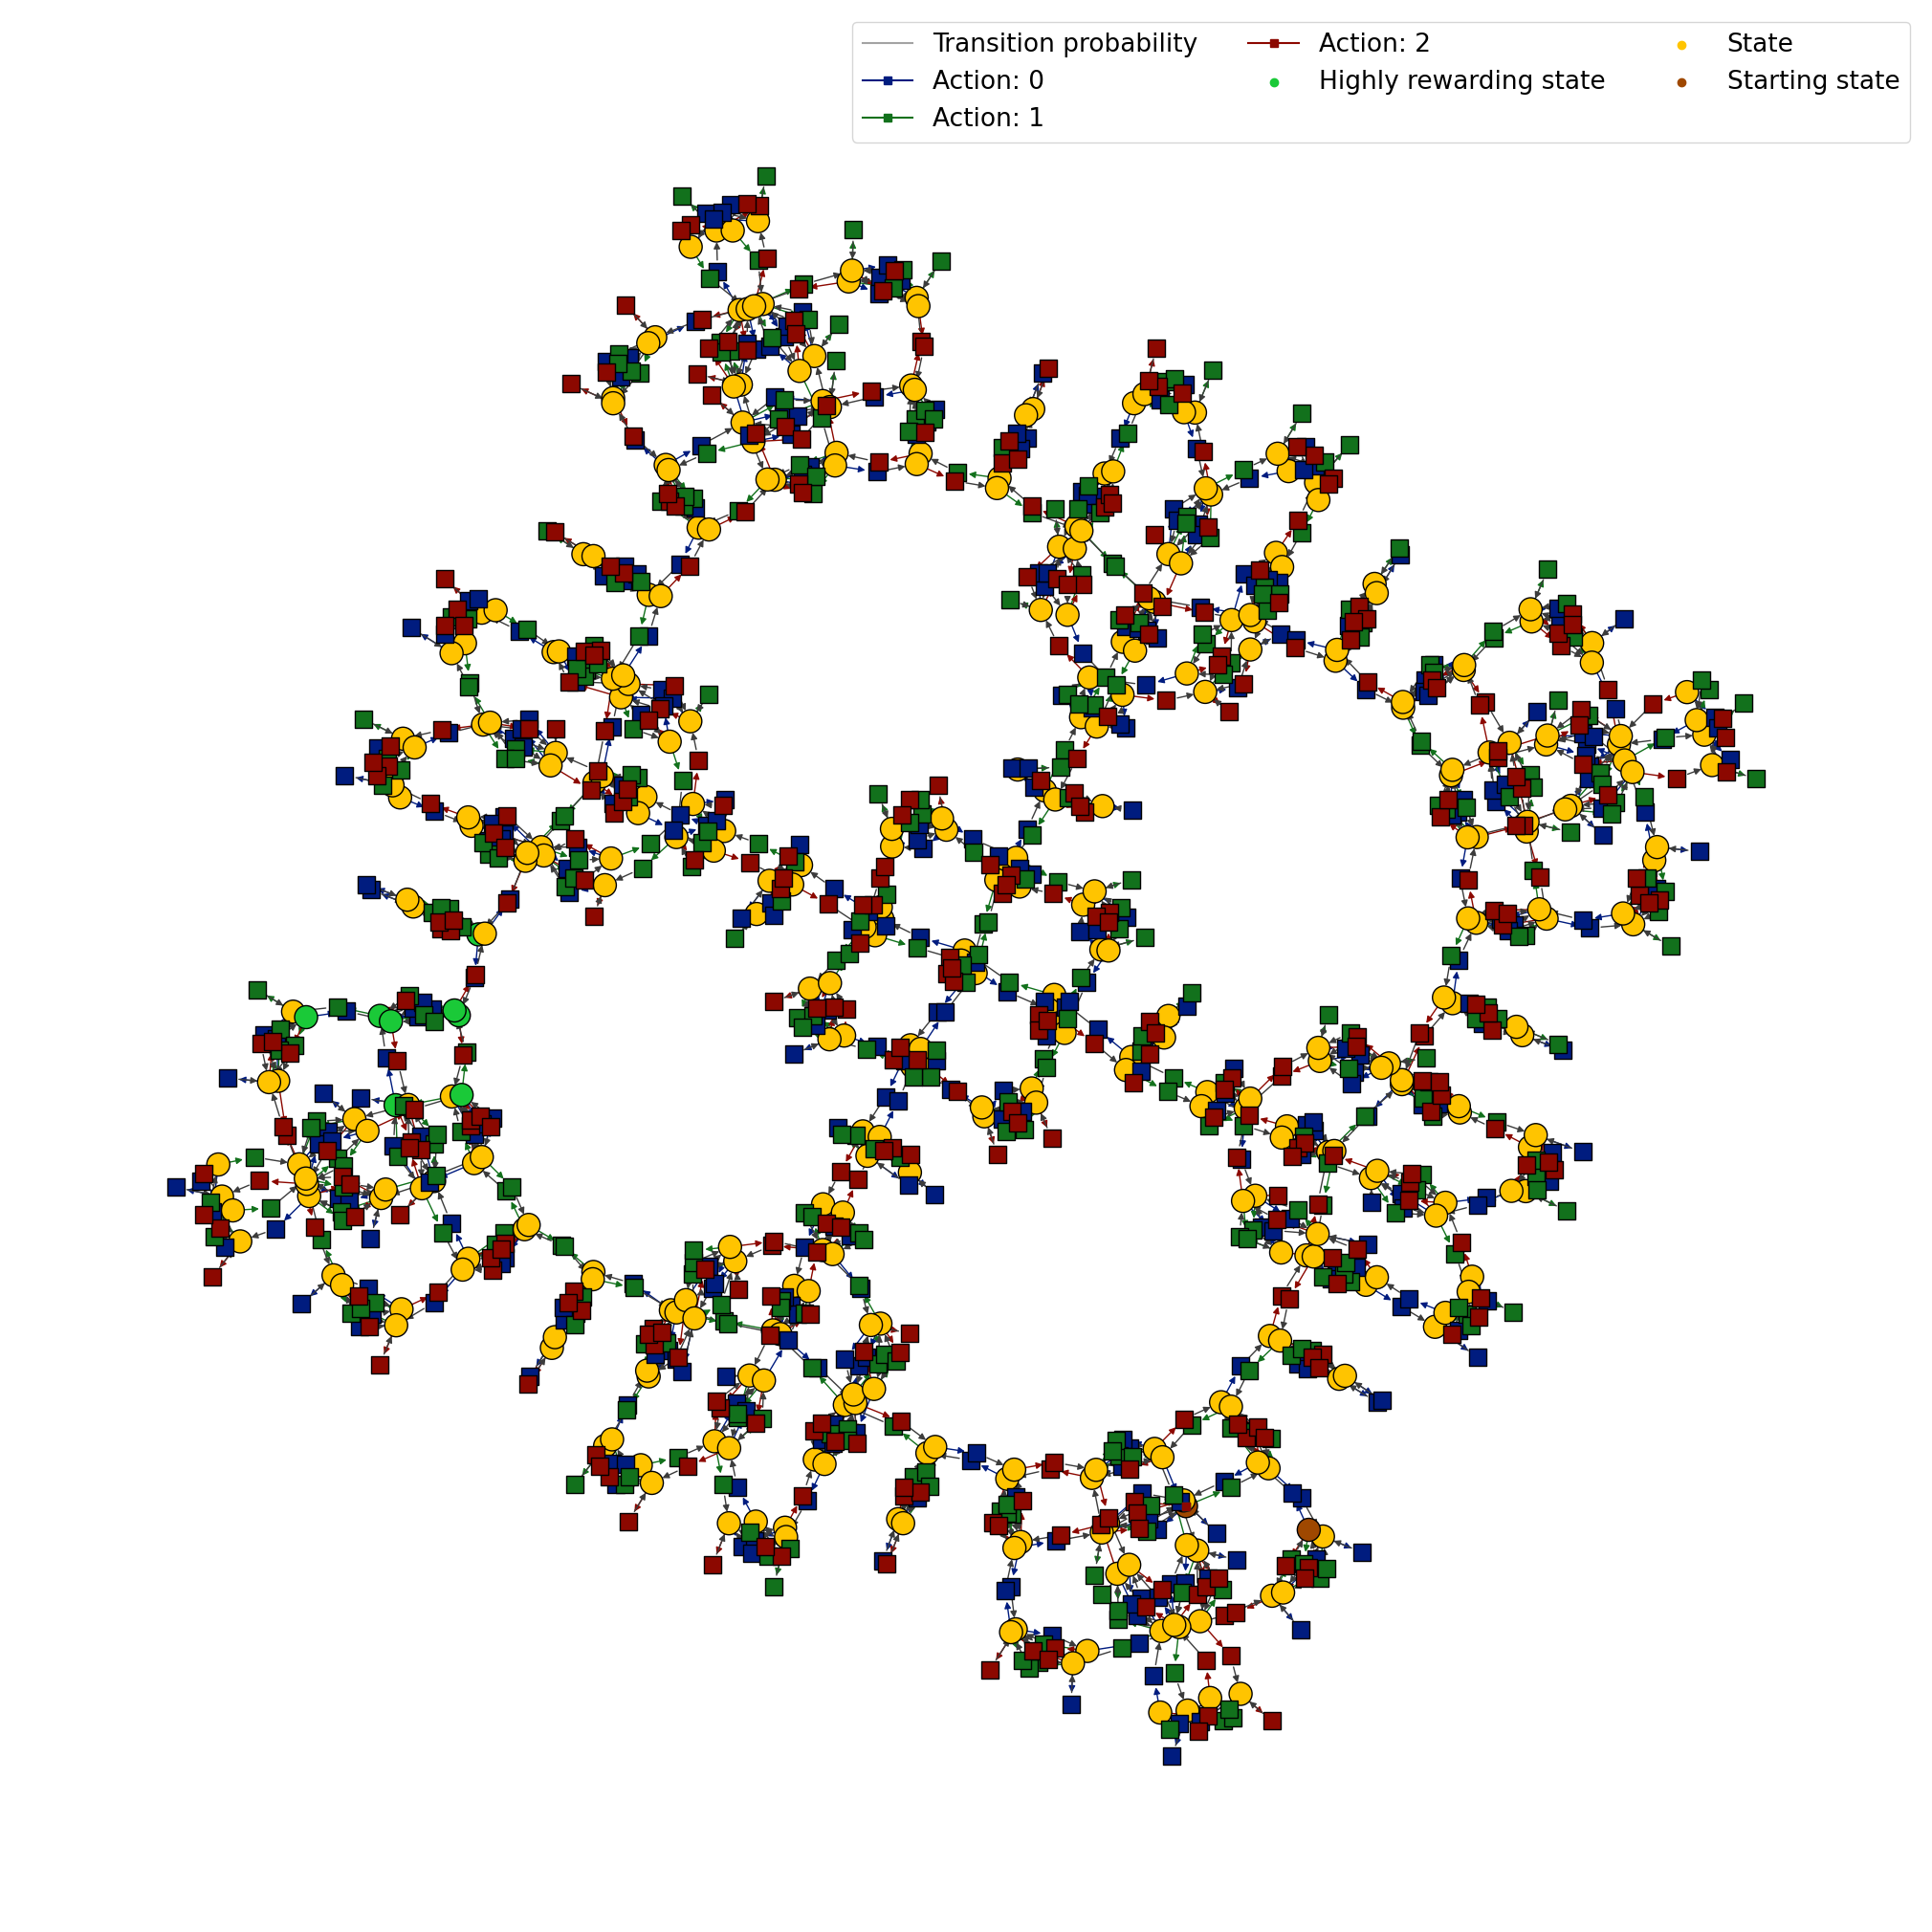

In [11]:
#@markdown ####  $\texttt{MiniGridRooms}$ MDP plot
#@markdown Approximate execution time: 30s

mdp = MiniGridRoomsContinuous(seed=0, room_size=3, n_rooms=9)
plot_MDP_graph(mdp, ncol=3, figsize=(20, 20), fontsize=19)

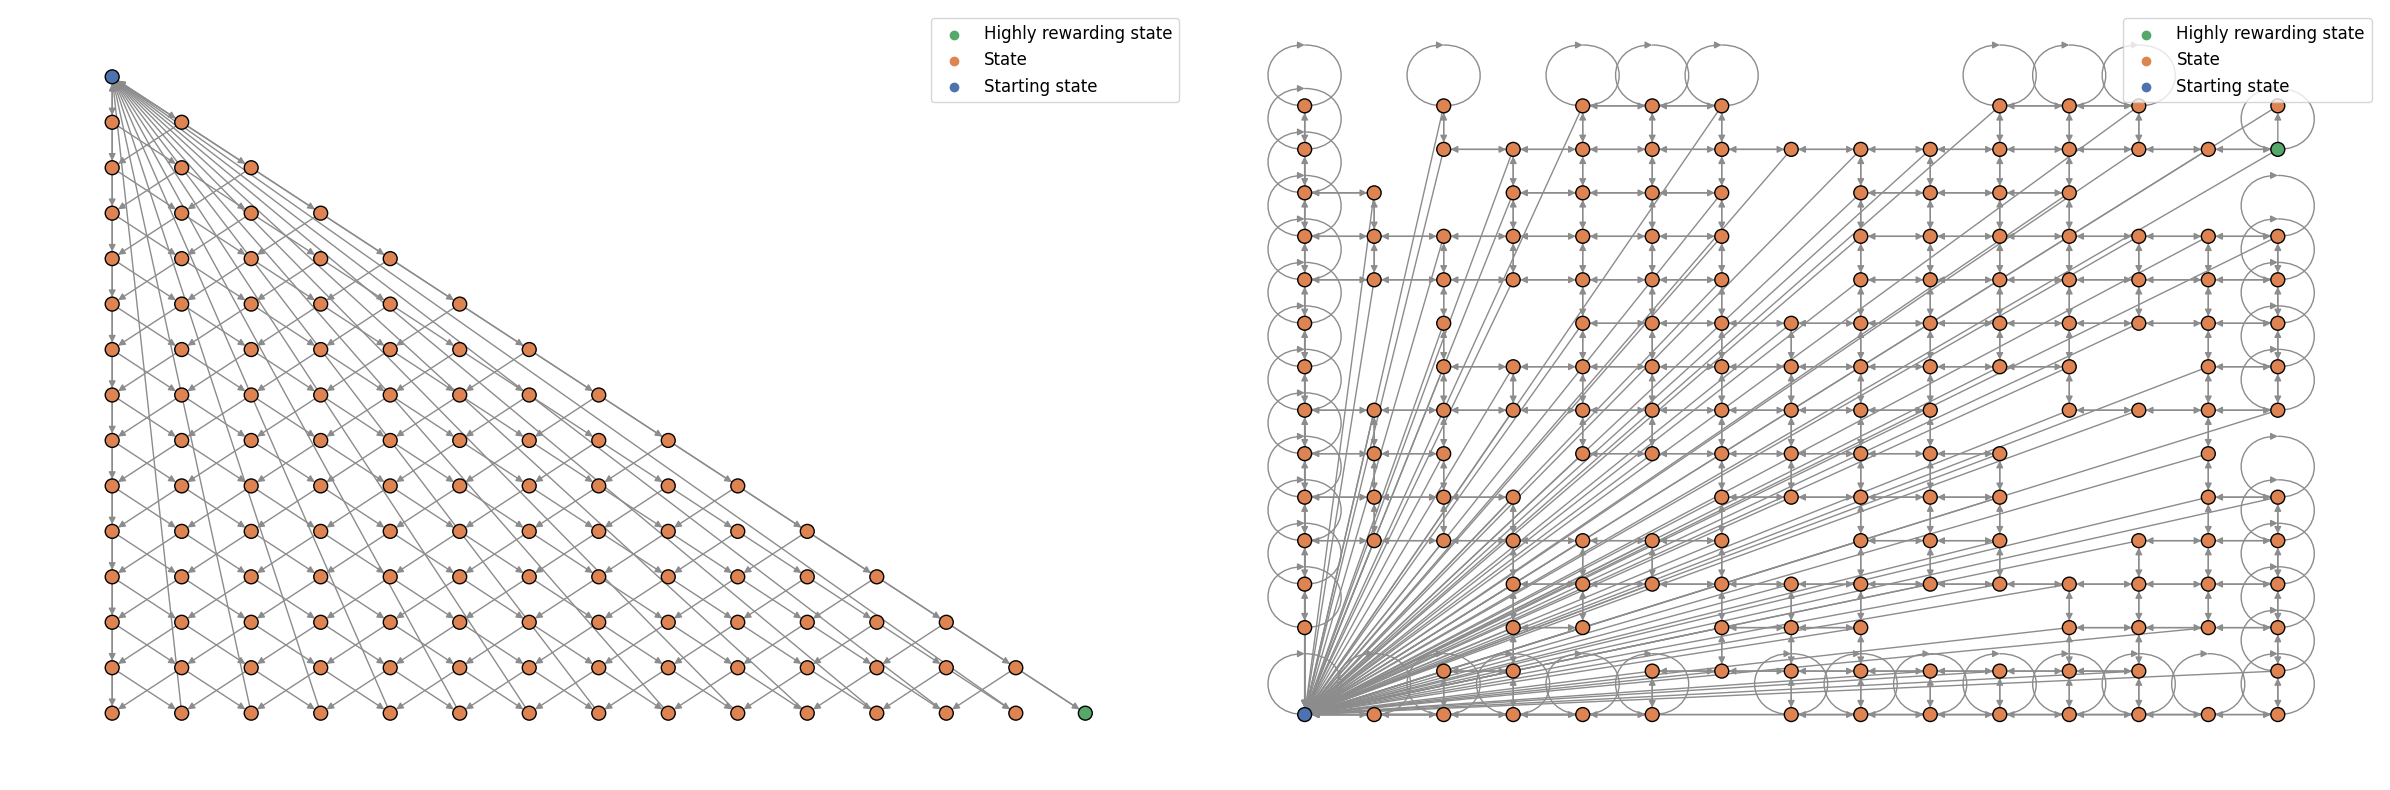

In [12]:
#@markdown ####  $\texttt{DeepSea}$ and $\texttt{FrozenLake}$ Markov chain plots
#@markdown Approximate execution time: 15s

fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (24, 8))

mdp = DeepSeaContinuous(seed=0, size=15, random_action_p=0.3)
plot_MCGraph(mdp, fontsize=12, ax=ax1)

mdp = FrozenLakeContinuous(seed=0, size=15, p_frozen=0.8)
plot_MCGraph(mdp, fontsize=12, ax=ax2)

plt.tight_layout()
plt.show()

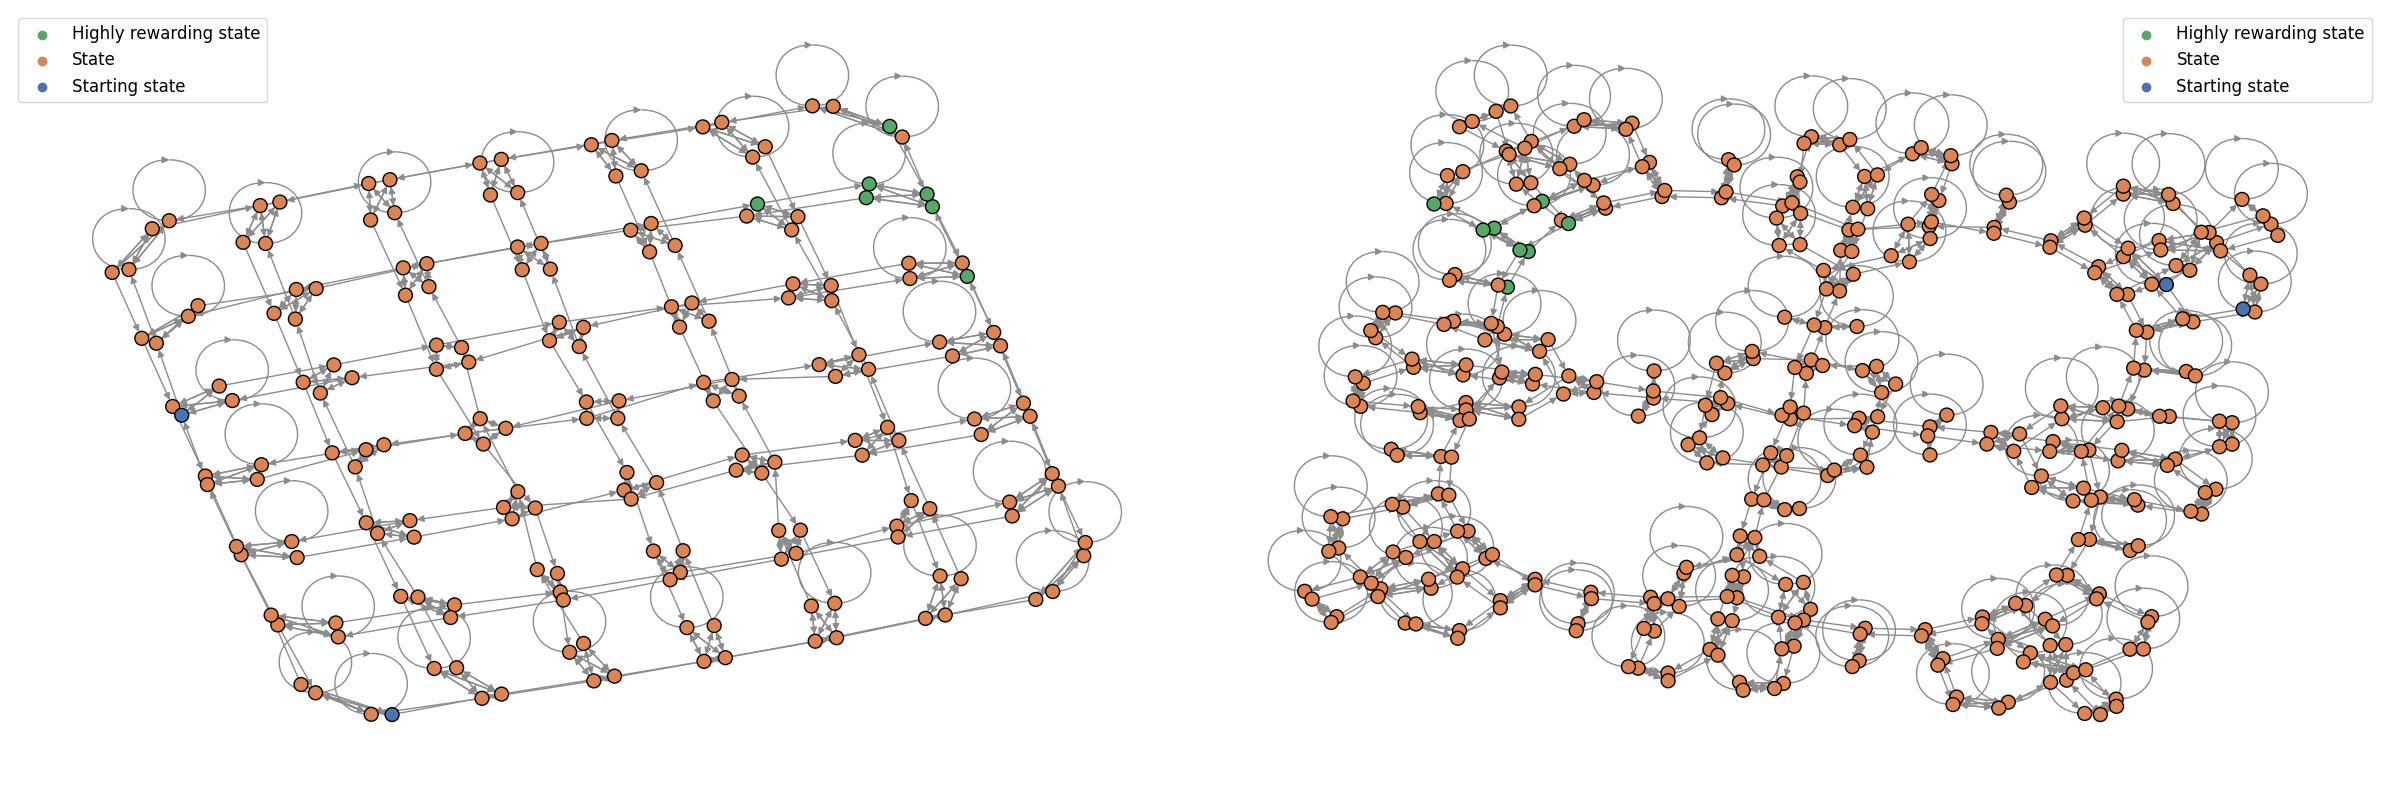

In [13]:
#@markdown ####  $\texttt{MiniGridEmpty}$ and $\texttt{MiniGridRooms}$ Markov chain plots
#@markdown Approximate execution time: 25s

fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (24, 8))

mdp = MiniGridEmptyContinuous(seed=0, size=7)
plot_MCGraph(mdp, fontsize=12, ax=ax1)

mdp = MiniGridRoomsContinuous(seed=0, room_size=3, n_rooms=9)
plot_MCGraph(mdp, fontsize=12, ax=ax2)

plt.tight_layout()
plt.show()

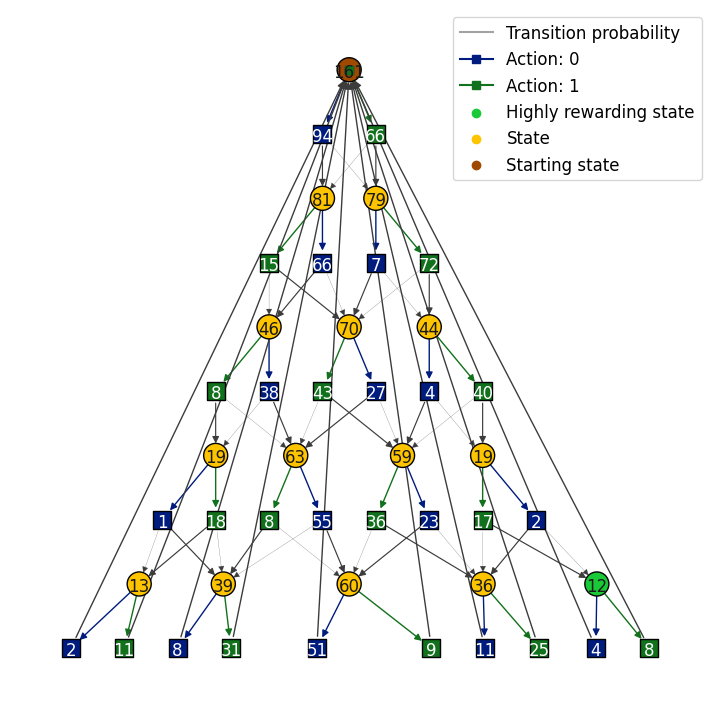

In [14]:
#@markdown ####  $\texttt{DeepSea}$ MDP plot with visitation counts.
#@markdown Approximate execution time: 3s

mdp = DeepSeaContinuous(seed=0, size=5, random_action_p=0.3)
mdp.reset()
for _ in range(800):
    mdp.random_step()
node_labels = mdp.get_visitation_counts()
action_labels = mdp.get_visitation_counts(False)
plot_MDP_graph(
    mdp,
    prog="dot",
    ncol=1,
    figsize=(7, 7),
    fontsize=12,
    node_labels=node_labels,
    action_labels=action_labels,
    int_labels_offset_x=0,
    int_labels_offset_y=0,
    font_color_state_actions_labels="white",
    no_written_state_action_labels = False,
    no_written_state_labels=False,
)

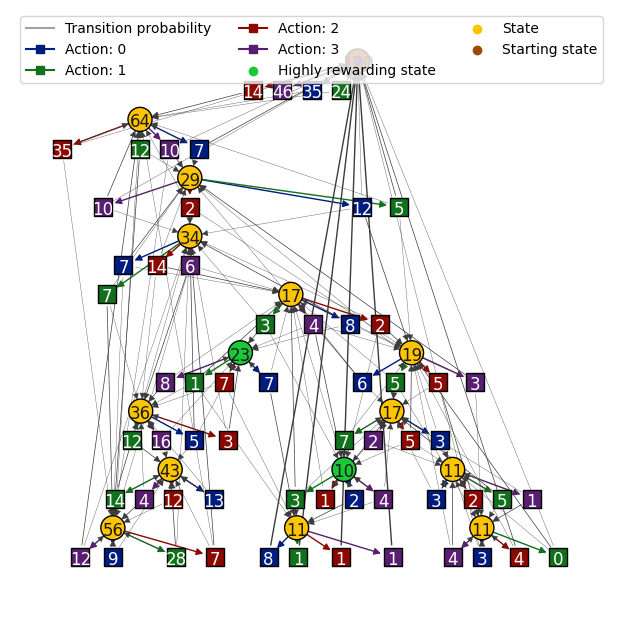

In [15]:
#@markdown ####  $\texttt{FrozenLake}$ MDP plot with visitation counts.
#@markdown Approximate execution time: 5s

mdp = FrozenLakeContinuous(seed=0, size=4, p_frozen=0.8)
mdp.reset()
for _ in range(500):
    mdp.random_step()
node_labels = mdp.get_visitation_counts()
action_labels = mdp.get_visitation_counts(False)
plot_MDP_graph(
    mdp,
    prog="dot",
    ncol=3,
    figsize=(6, 6),
    node_labels=node_labels,
    action_labels=action_labels,
    int_labels_offset_x=0,
    int_labels_offset_y=0,
    font_color_state_actions_labels="white",
    no_written_state_action_labels = False,
    no_written_state_labels=False,
)

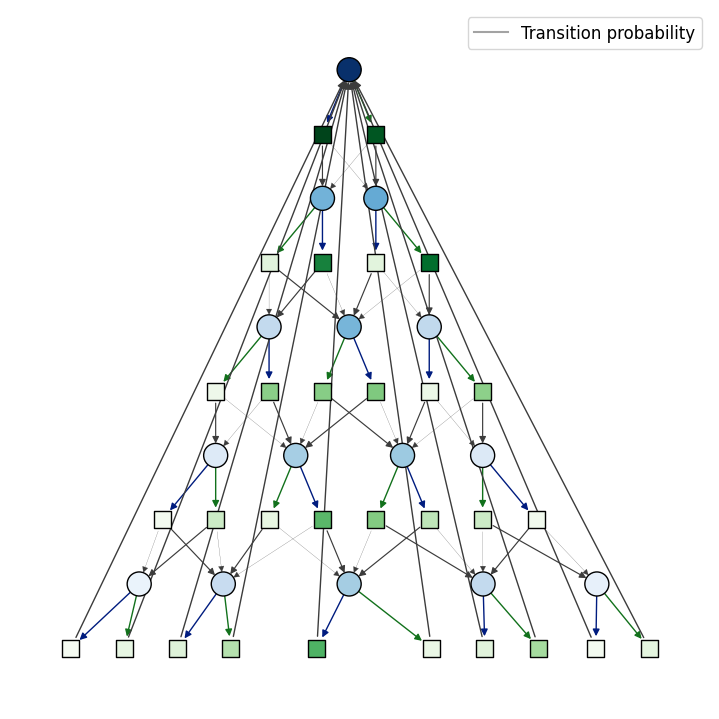

In [16]:
#@markdown ####  $\texttt{DeepSea}$ MDP plot with visitation heatmap.
#@markdown Approximate execution time: 5s

mdp = DeepSeaContinuous(seed=0, size=5, random_action_p=0.3)
mdp.reset()
for _ in range(5000):
    mdp.random_step()
node_labels = mdp.get_visitation_counts()
action_labels = mdp.get_visitation_counts(False)
plot_MDP_graph(
    mdp,
    prog="dot",
    ncol=1,
    figsize=(7, 7),
    fontsize=12,
    node_labels=node_labels,
    action_labels=action_labels,
    cm_state_labels=matplotlib.cm.get_cmap("Blues"),
    cm_state_actions_labels=matplotlib.cm.get_cmap("Greens"),
)

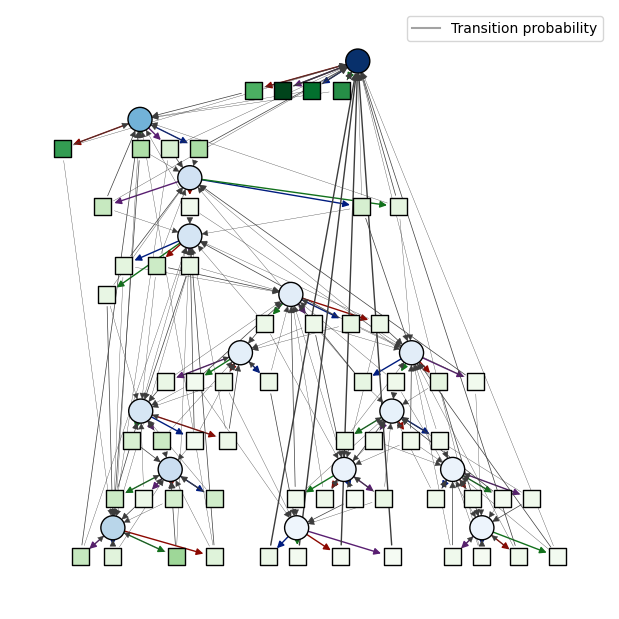

In [17]:
#@markdown ####  $\texttt{FrozenLake}$ MDP plot with visitation heatmap.
#@markdown Approximate execution time: 5s

mdp = FrozenLakeContinuous(seed=0, size=4, p_frozen=0.8)
mdp.reset()
for _ in range(5000):
    mdp.random_step()
node_labels = mdp.get_visitation_counts()
action_labels = mdp.get_visitation_counts(False)
plot_MDP_graph(
    mdp,
    prog="dot",
    ncol=3,
    figsize=(6, 6),
    node_labels=node_labels,
    action_labels=action_labels,
    cm_state_labels=matplotlib.cm.get_cmap("Blues"),
    cm_state_actions_labels=matplotlib.cm.get_cmap("Greens"),
)

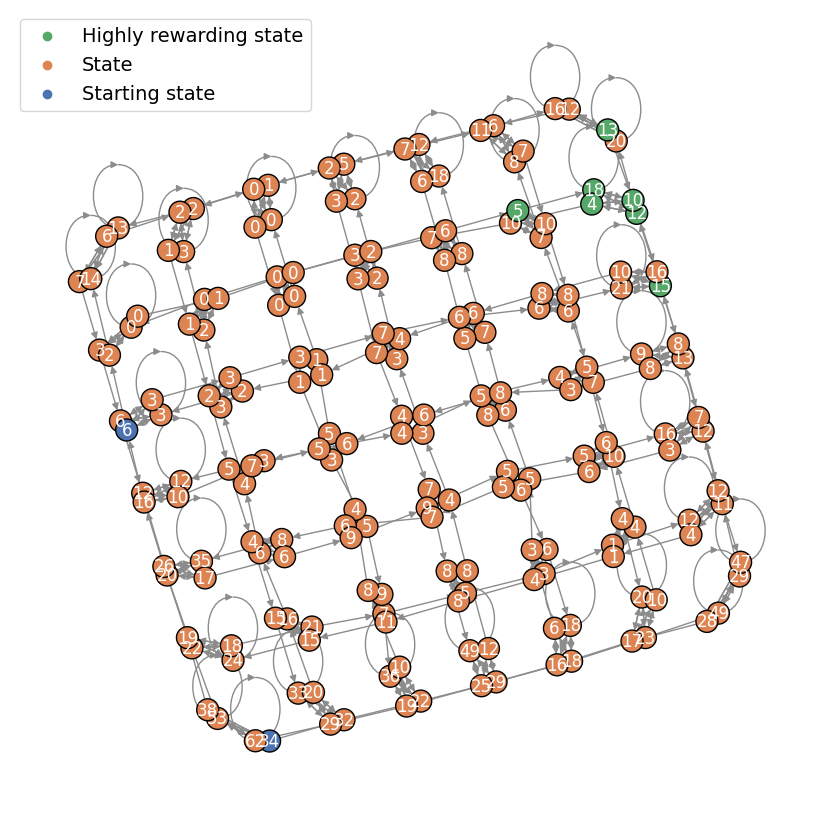

In [18]:
#@markdown ####  $\texttt{MiniGridEmpty}$ MDP plot with visitation counts.
#@markdown Approximate execution time: 10s

mdp = MiniGridEmptyContinuous(seed=0, size=7)
mdp.reset()
for _ in range(2000):
    mdp.random_step()
node_labels = mdp.get_visitation_counts()
plot_MCGraph(
    mdp,
    figsize=(8, 8),
    fontsize=14,
    labels=node_labels,
    node_size=250,
    font_color_labels="white",
)

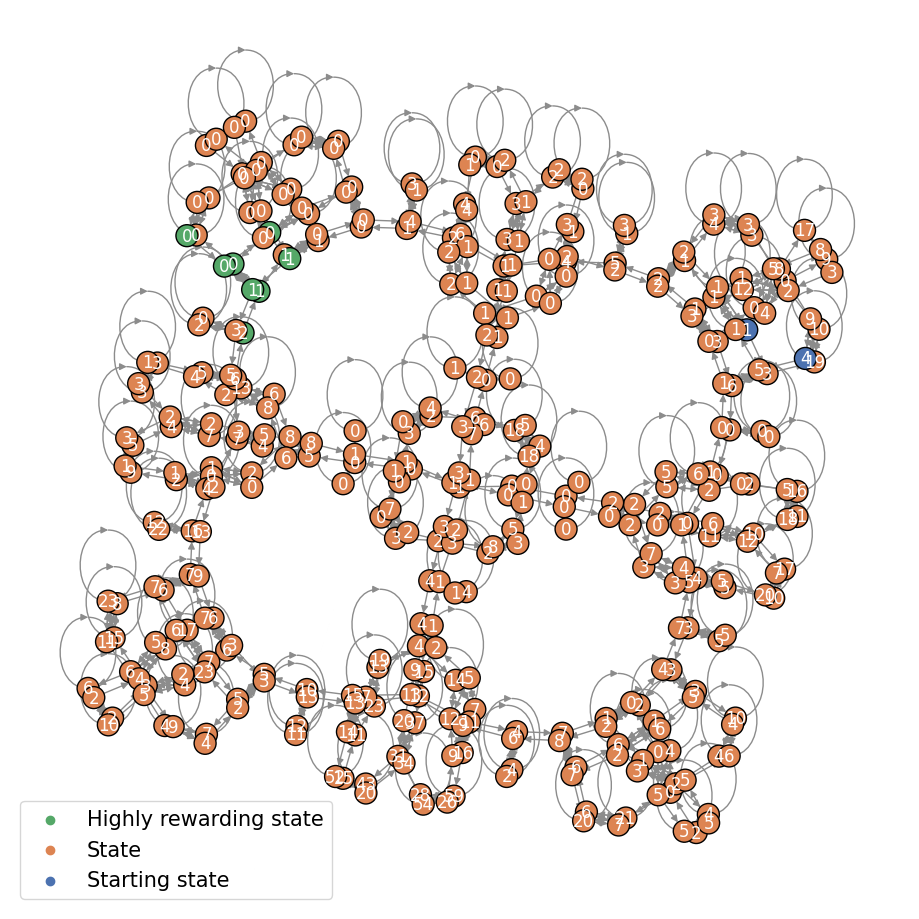

In [19]:
#@markdown ####  $\texttt{MiniGridRooms}$ MDP plot with visitation counts.
#@markdown Approximate execution time: 25s

mdp = MiniGridRoomsContinuous(seed=0, room_size=3, n_rooms=9)
mdp.reset()
for _ in range(2000):
    mdp.random_step()
node_labels = mdp.get_visitation_counts()
plot_MCGraph(
    mdp,
    figsize=(9, 9),
    fontsize=15,
    labels=node_labels,
    node_size=250,
    font_color_labels="white",
)

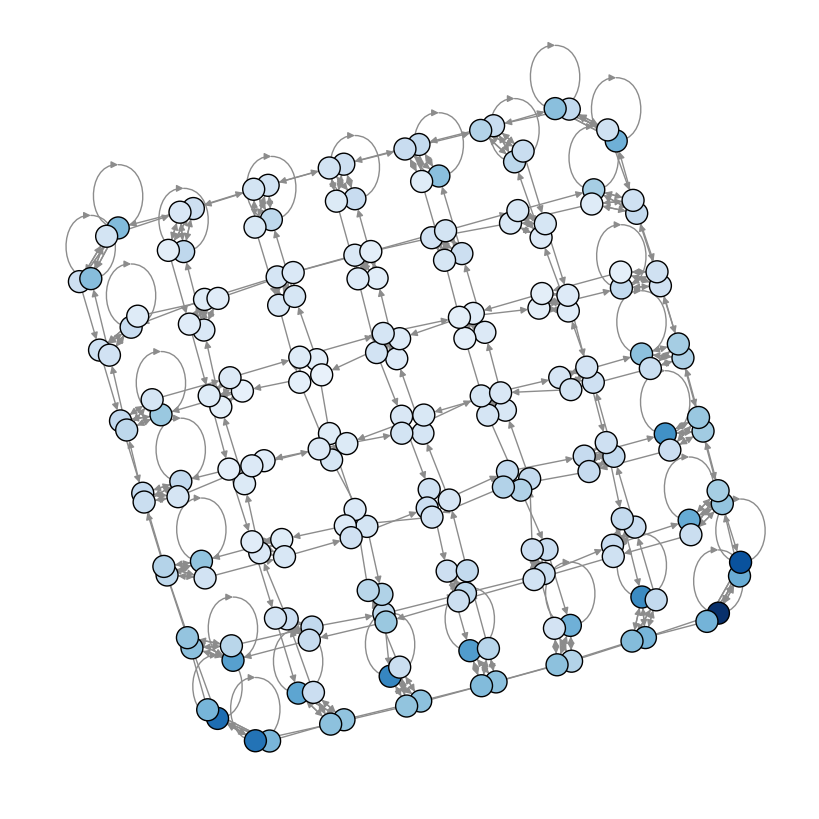

In [20]:
#@markdown ####  $\texttt{MiniGridEmpty}$ MDP plot with visitation heatmap.
#@markdown Approximate execution time: 10s

mdp = MiniGridEmptyContinuous(seed=0, size=7)
mdp.reset()
for _ in range(10_000):
    mdp.random_step()
node_labels = mdp.get_visitation_counts()
plot_MCGraph(
    mdp,
    figsize=(8, 8),
    fontsize=14,
    labels=node_labels,
    node_size=250,
    cm_state_labels=matplotlib.cm.get_cmap("Blues"),
)

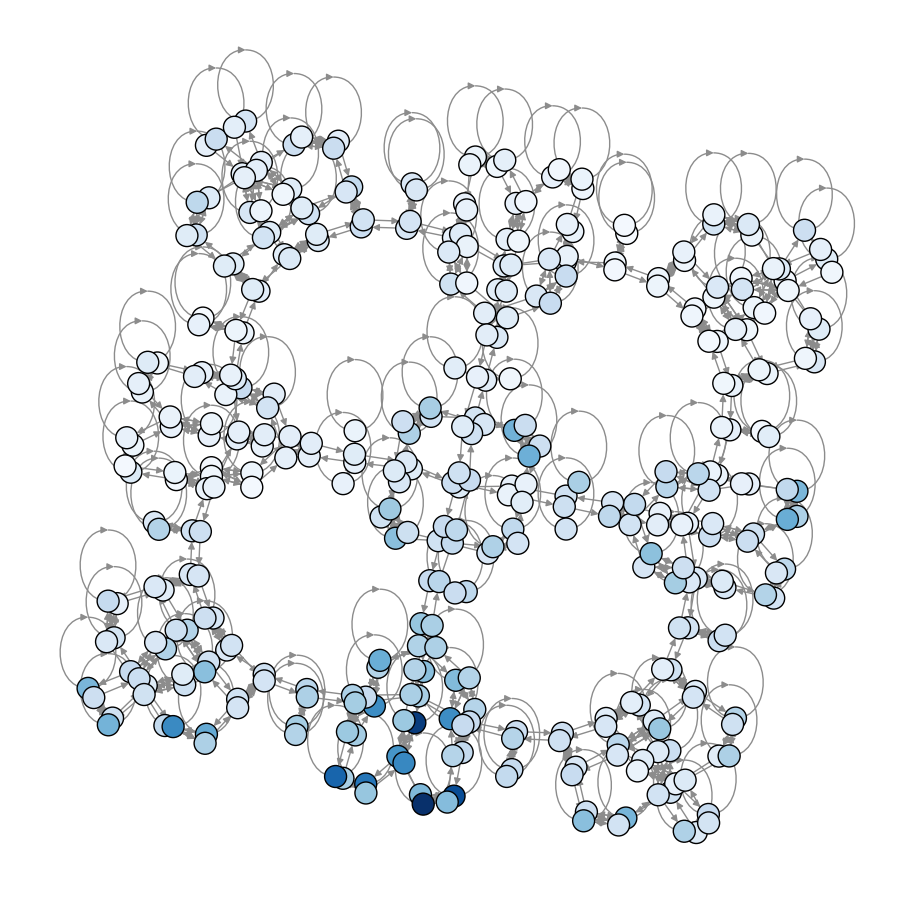

In [21]:
#@markdown ####  $\texttt{MiniGridRooms}$ MDP plot with visitation heatmap.
#@markdown Approximate execution time: 10s

mdp = MiniGridRoomsContinuous(seed=0, room_size=3, n_rooms=9)
mdp.reset()
for _ in range(10_000):
    mdp.random_step()
node_labels = mdp.get_visitation_counts()
plot_MCGraph(
    mdp,
    figsize=(9, 9),
    fontsize=15,
    labels=node_labels,
    node_size=250,
    cm_state_labels=matplotlib.cm.get_cmap("Blues"),
)

## Benchmarks results analysis

In this section, we demonstrate how to analyse the result of the benchmark using the same data presented in the paper.






100%|██████████| 40/40 [00:00<00:00, 26483.37it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


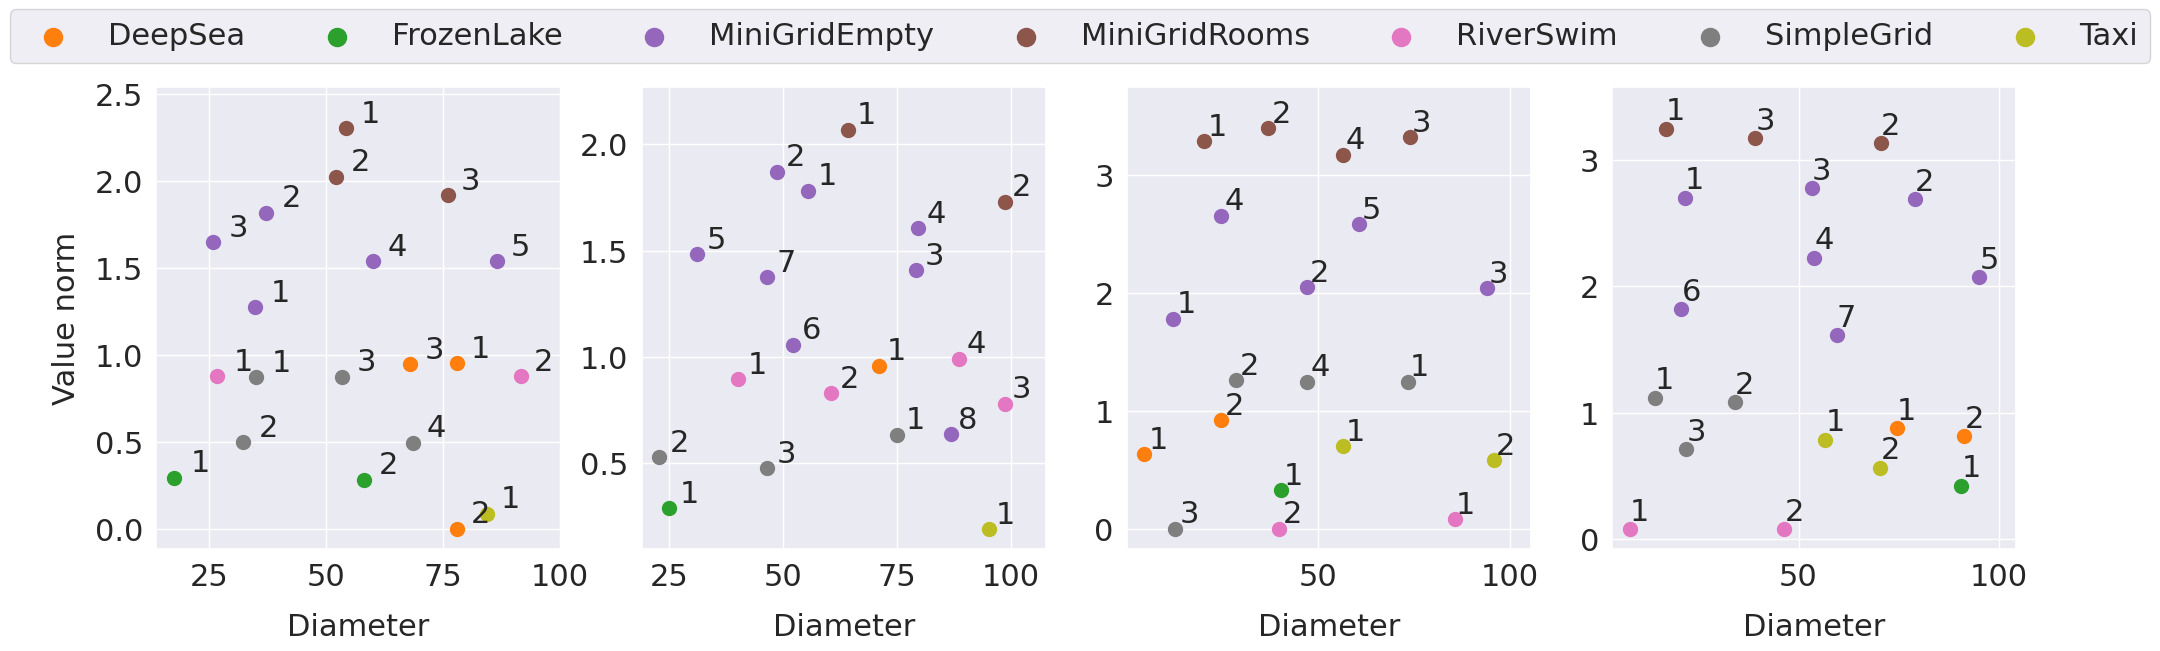

In [22]:
#@markdown #### Hardness of the MDPs in the benchmark
#@markdown In order to investigate the hardness of the MDPs in the benchmark, we
#@markdown position each MDP according to their diameters and environmental value norms.

#@markdown Approximate execution time: 10s
sns.set_theme()

mdp_names = list(sorted(set(clear_th(x.__name__) for x in get_all_mdp_classes())))
COLORS = list(matplotlib.colors.TABLEAU_COLORS.keys())
fig, axes = plt.subplots(1, 4, figsize=(4 * 6, 6))  # , sharey=True)
for ii, exp_to_show in enumerate(available_experiments):
    plot_labels_on_benchmarks_hardness_space(
        exp_to_show,
        text_f=lambda x: str(int(x[1][-1]) + 1),
        color_f=lambda x: COLORS[mdp_names.index(clear_th(x[0]))],
        label_f=lambda x: clear_th(x[0]) if "0" in x[1] else None,
        ax=axes[ii],
        multiplicative_factor_xlim=1.05,
        multiplicative_factor_ylim=1.05,
        set_ylabel=ii == 0,
        set_legend=False,
    )

leg = plt.legend(
    fontsize=22,
    ncol=8,
    loc="center left",
    bbox_to_anchor=(-4.0, 1.11),
    markerscale=1.3,
)
for x in leg.get_lines():
    x.set_linewidth(4)
plt.tight_layout()
plt.show()

### Cumulative regrets in hardness space

In order to illustrate how hardness measures relate with cumulative regret and empirically valide the benchmark, we place the average cumulative regret obtained by each agent in each continuous ergodic MDP in a coordinate that corresponds to the diameter and the environmental value norm of that MDP.

Approximate total execution time: 20s

100%|██████████| 60/60 [00:00<00:00, 126716.13it/s]


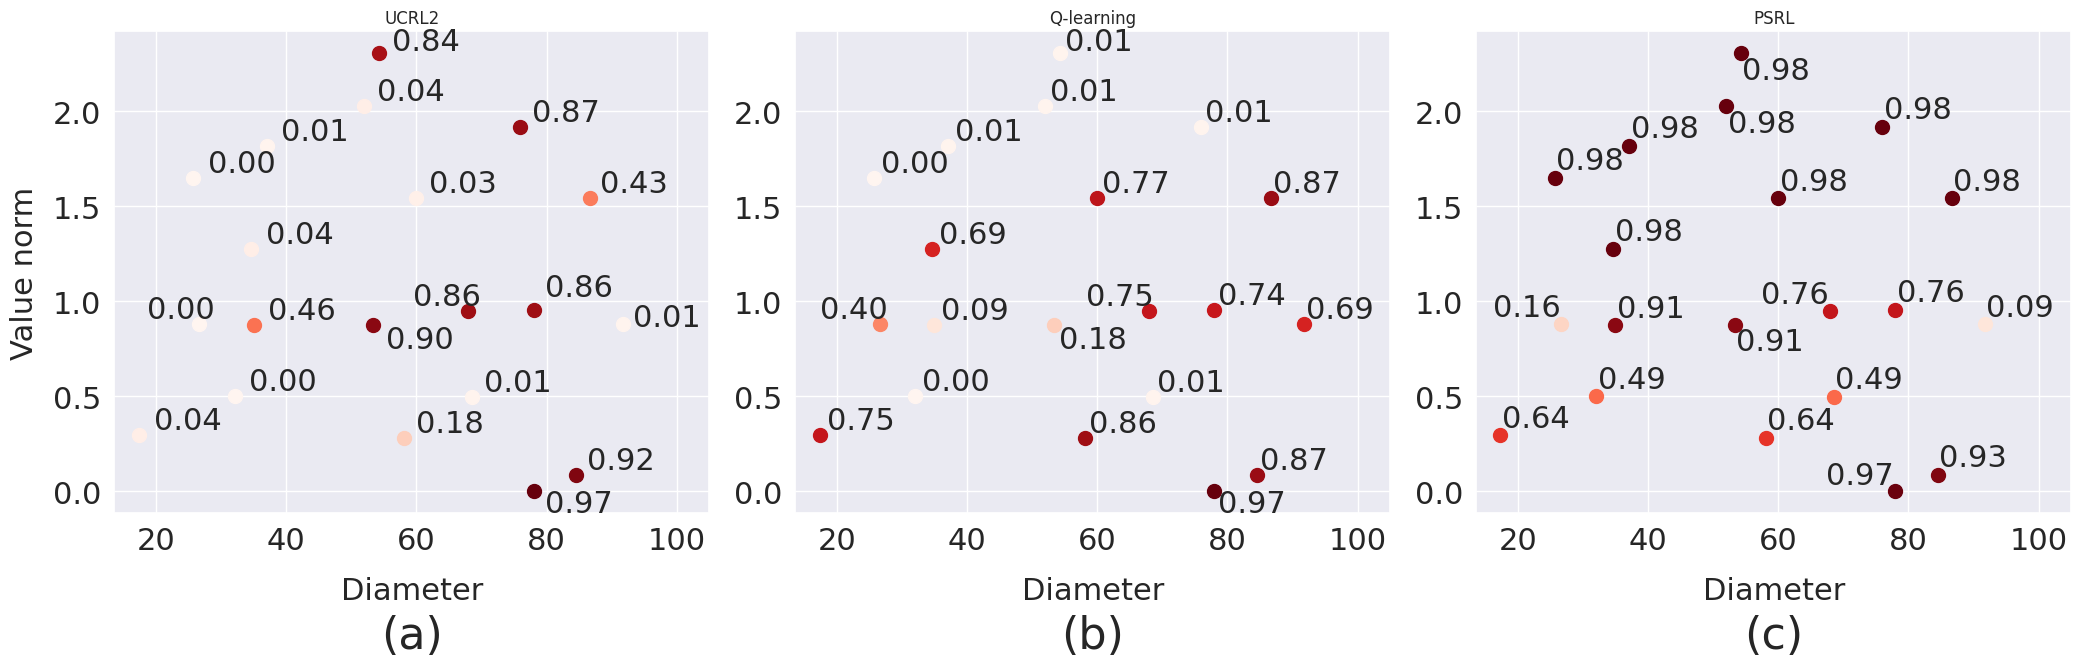

In [23]:
#@markdown ####  Benchmark continuous communicating
#@markdown Increasing values of the diameter produce notable increases in the cumulative
#@markdown regrets of UCRL2 and QLearning but not for PSRL.
#@markdown The different value of the environmental value norm has different 
#@markdown effects for each agent. For UCRL2, we do not notice any significant
#@markdown change. For QLeaning, higher values of this measure of hardness 
#@markdown decrese the cumulative regrets whereas the opposite holds for PSRL.

crs_in_hardness_space(available_experiments[0])

100%|██████████| 60/60 [00:00<00:00, 61620.53it/s]


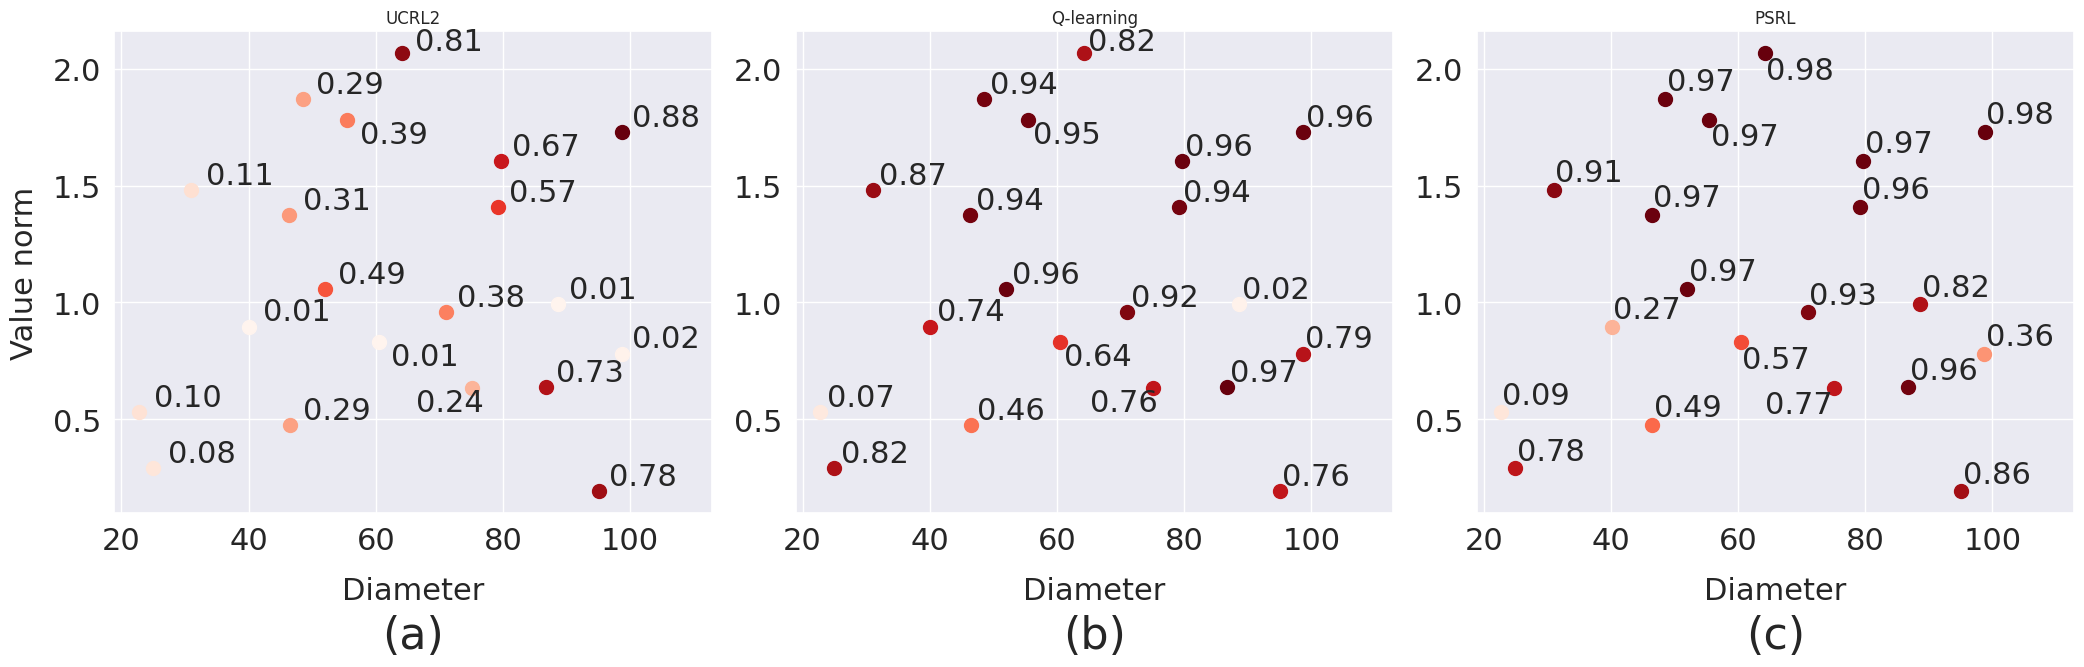

In [24]:
#@markdown ####  Benchmark continuous ergodic
#@markdown In the ergodic case, the effect of increasing values of the diameter
#@markdown is comparable to the communicating case.
#@markdown On the contrary, higher values of the environmental value norms are
#@markdown associated with higher cumualtive regrets for all the agents.

crs_in_hardness_space(available_experiments[1])

100%|██████████| 40/40 [00:00<00:00, 107684.31it/s]


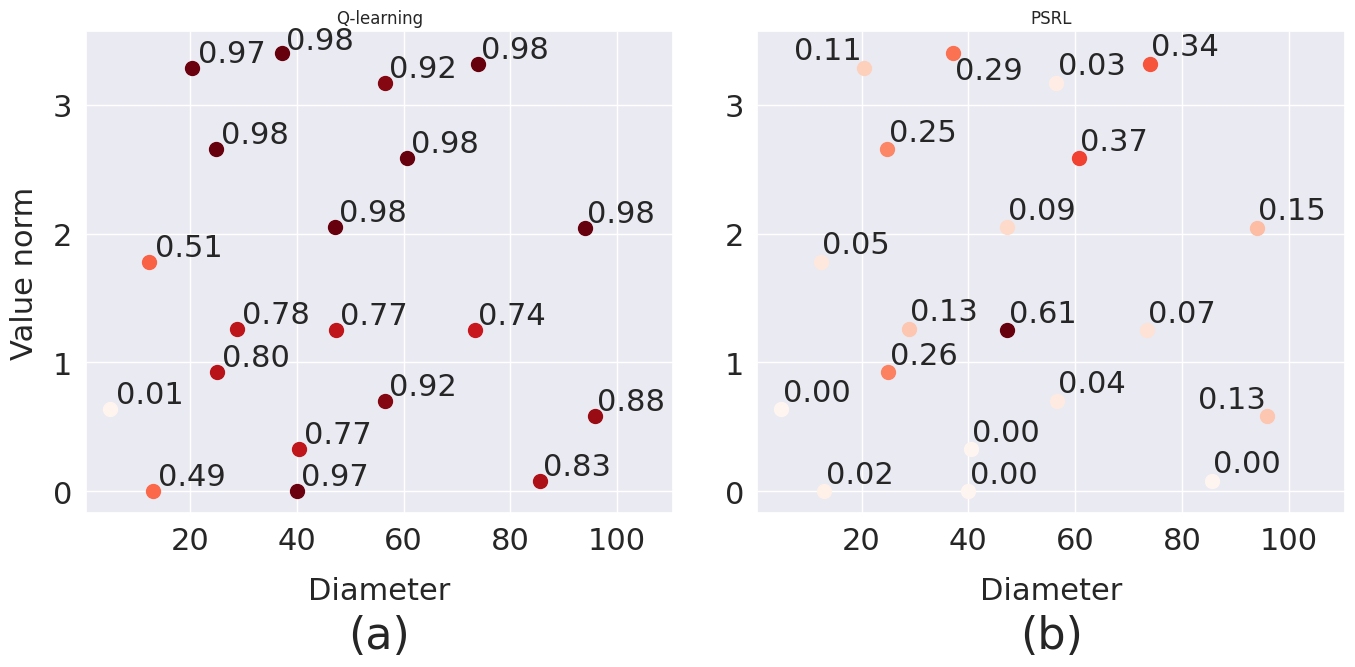

In [25]:
#@markdown ####  Benchmark episodic communicating
#@markdown The increases in cumulative regrets induced by the diameter are not
#@markdown particular significant compared to the one induced by increasing
#@markdown of the value norm, especially for the PSRL agent.

crs_in_hardness_space(available_experiments[2])

100%|██████████| 40/40 [00:00<00:00, 87792.86it/s]


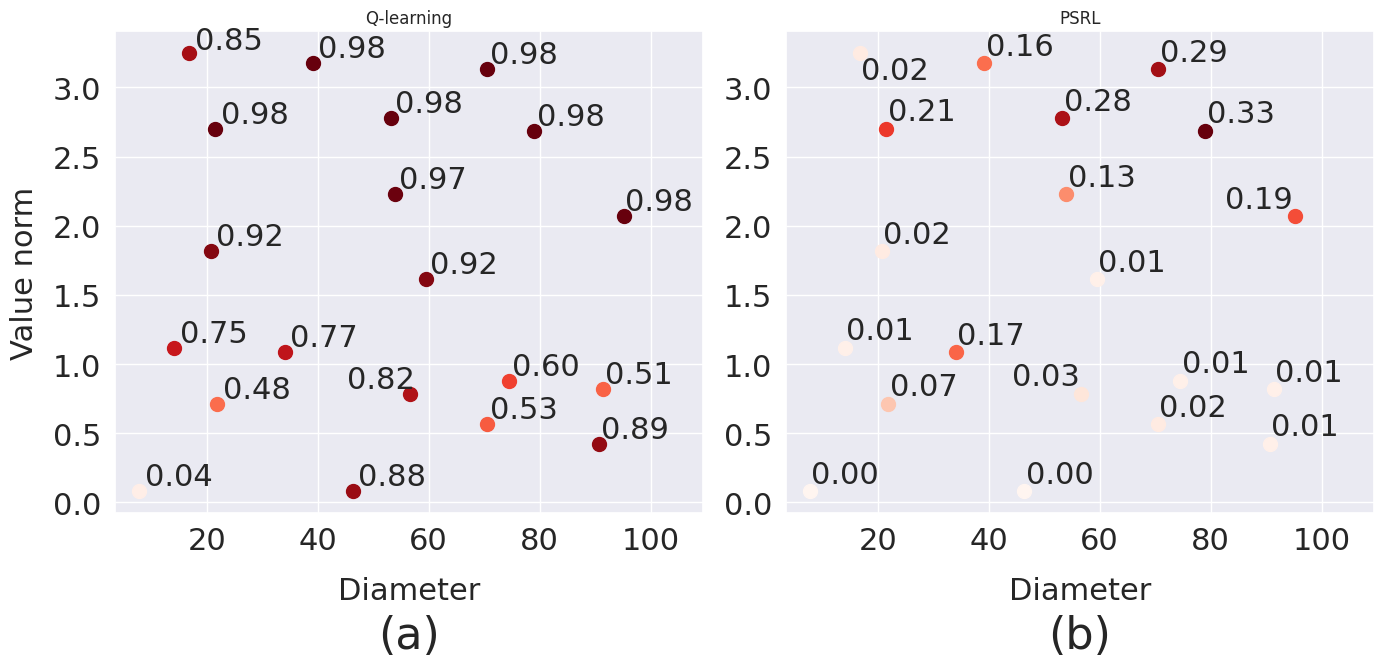

In [26]:
#@markdown ####  Benchmark episodic ergodic
#@markdown Contrary to the communicating case, increasing values of the diameter
#@markdown yield significant increases of the regrets, especially for high
#@markdown values of environmental value norm.
#@markdown Similarly to the previous scenario, the environmental value norm drives
#@markdown notable increases in the regrets of the agents.

crs_in_hardness_space(available_experiments[3])

0) benchmark_continuous_communicating
1) benchmark_continuous_ergodic
2) benchmark_episodic_communicating
3) benchmark_episodic_ergodic
Please select between the following options or enter any other character to return to the previous menu.0
You have selected the experiment: "benchmark_continuous_communicating"
0) Show the table with the final results.
1) Show the table with the final results in LaTex.
2) Proceed to the plotting functionalities.
Please select between the following options or enter any other character to return to the previous menu.2
Please select between the following options or enter any other character to return to the previous menu.
0) Group by MDP.
1) Group by agents.
0
0) cumulative_regret
1) cumulative_return
2) normalized_cumulative_regret
3) steps_per_second
Please select between the following options or enter any other character to return to the previous menu.2


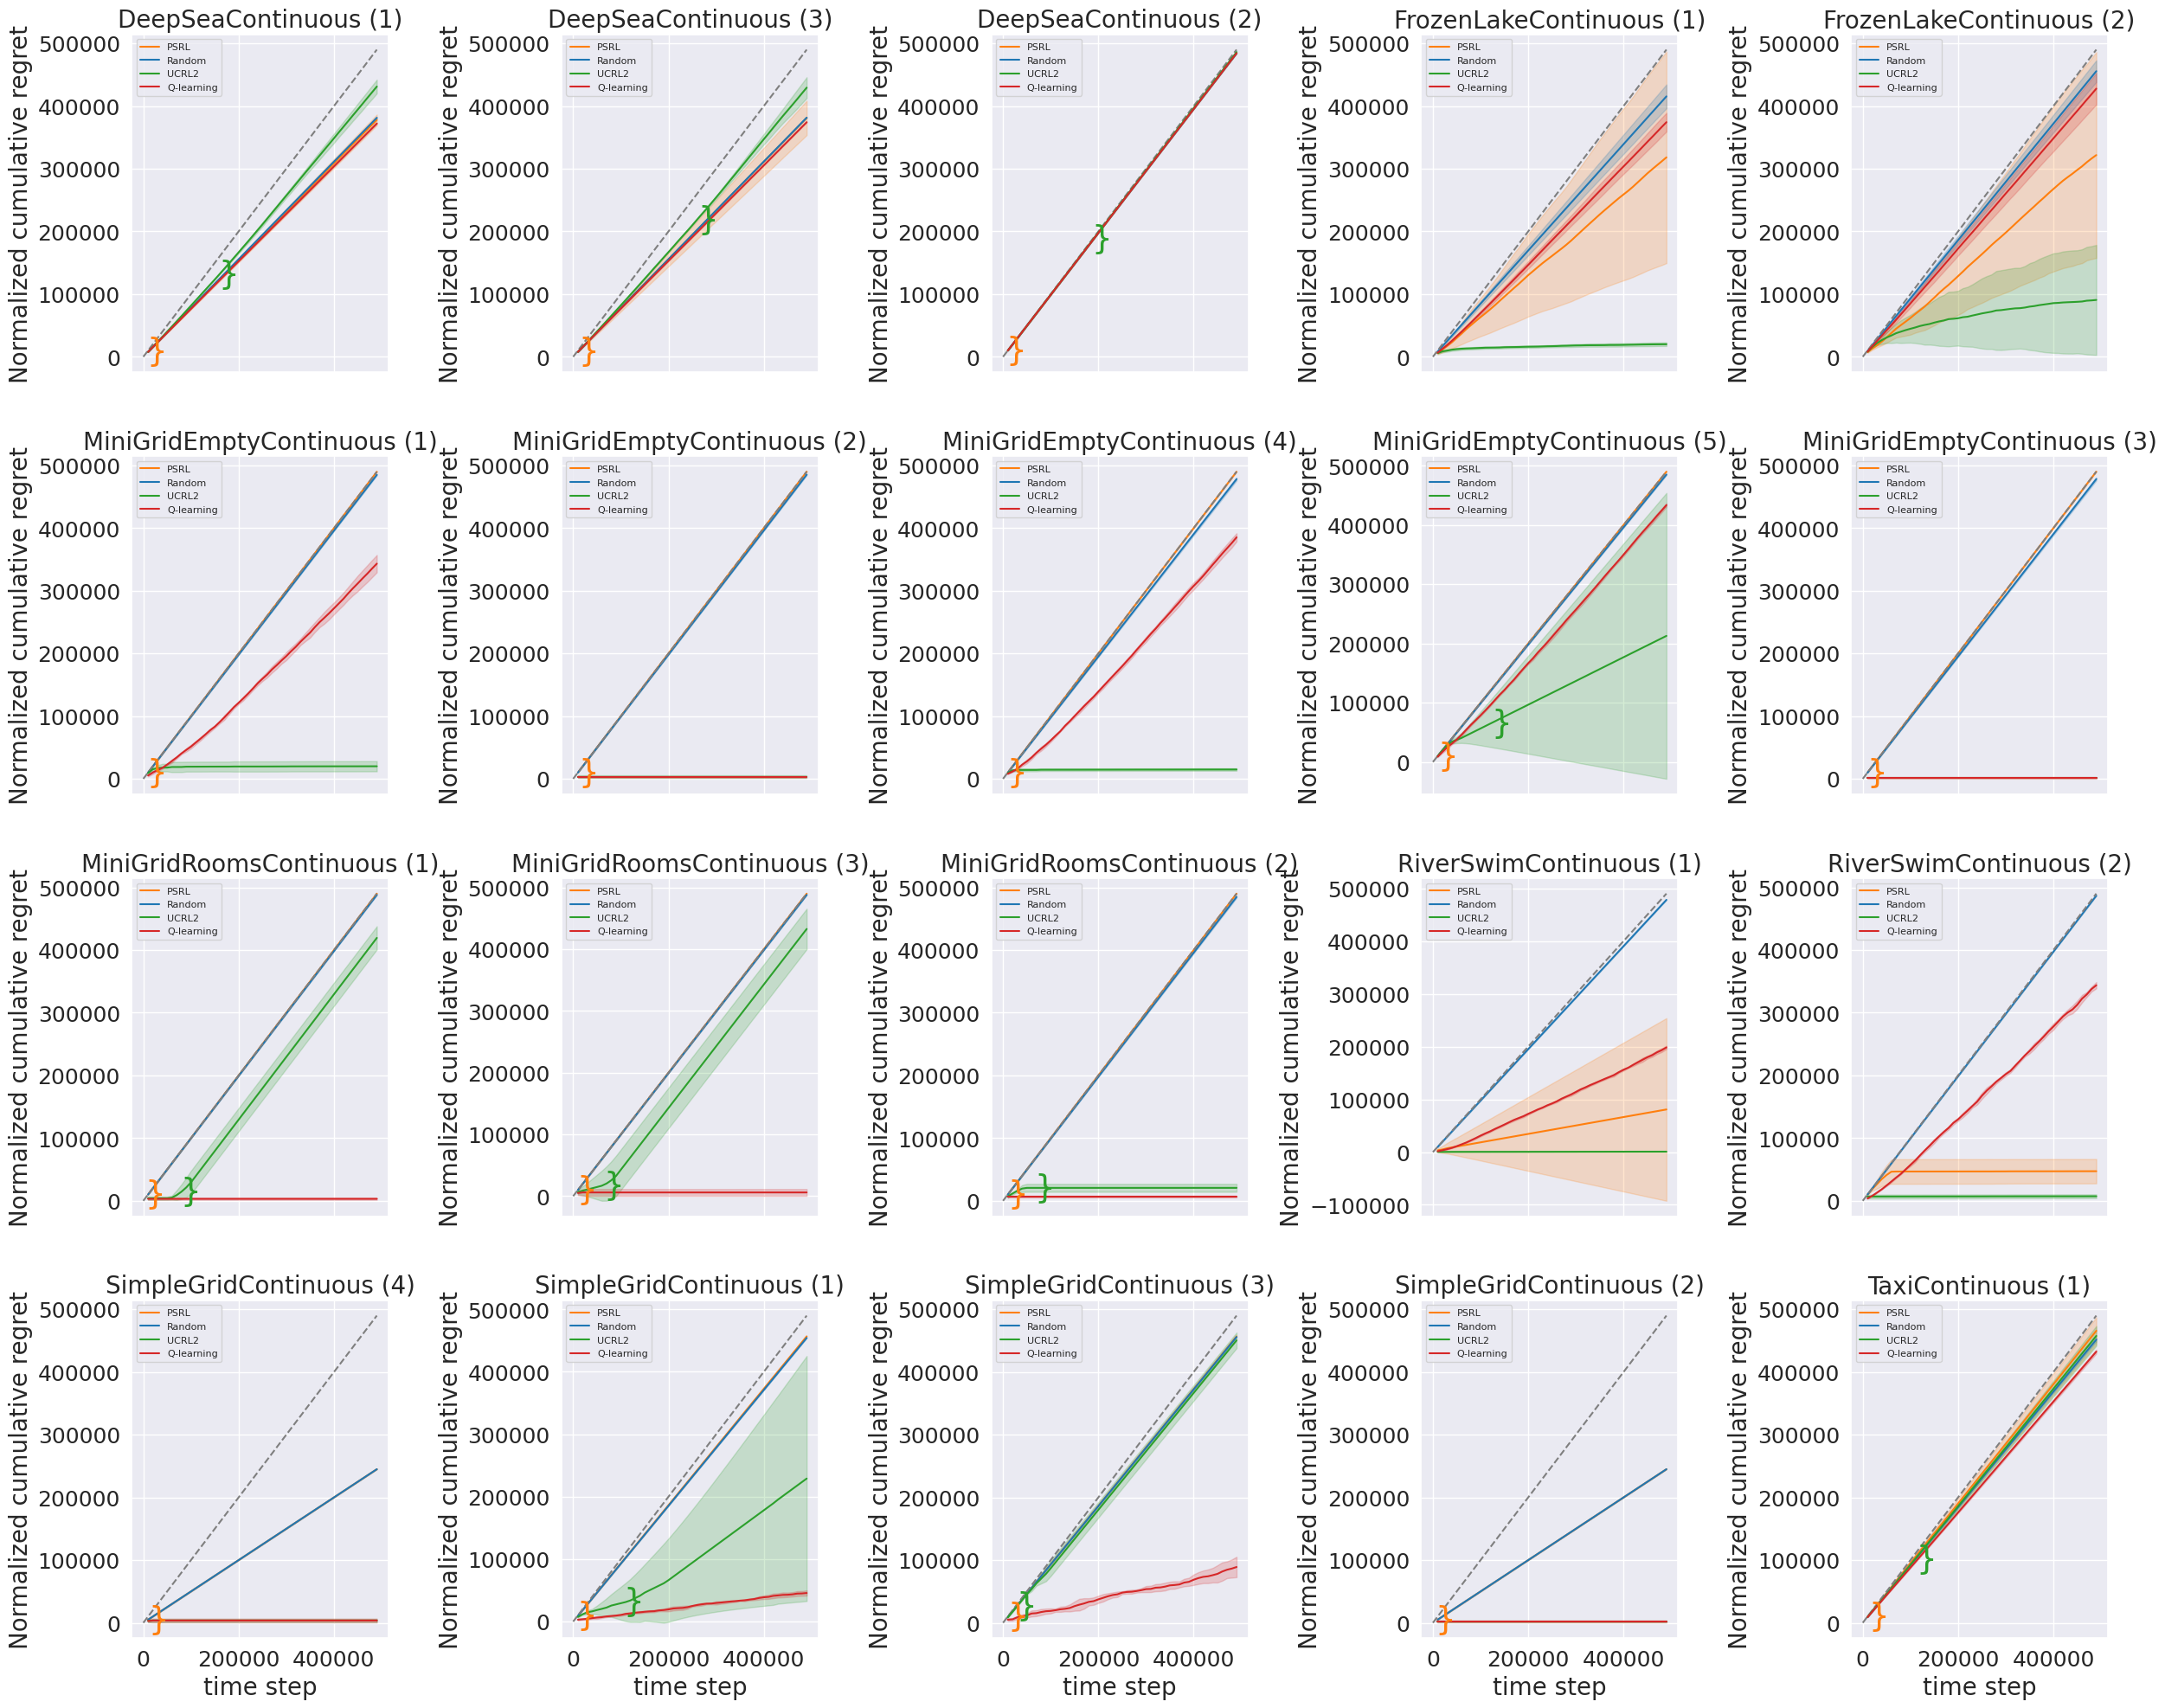

Please select between the following options or enter any other character to return to the previous menu.
0) Group by MDP.
1) Group by agents.
64464
0) benchmark_continuous_communicating
1) benchmark_continuous_ergodic
2) benchmark_episodic_communicating
3) benchmark_episodic_ergodic
Please select between the following options or enter any other character to return to the previous menu.4646


In [27]:
#@markdown ####  Interactive analysis of the benchmarks results.
#@markdown In addition to the previous visualizations, $\texttt{Colosseum}$ offers an interactive analysis of the results.
#@markdown It is possible to group the results *by MDP* to analyse the performances of the agents on the MDPs in the benchmark,
#@markdown or to group *by agent*, to investigate how the parameters/hardness of the MDPs influences the final
#@markdown cumulative regrets.

analyze(w=5)